In [1]:
# Standard libraries
import time

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx

Function to check for overlaps

In [2]:
def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - intersect: True if the line segments intersect, False otherwise.
    """
    def orientation(p, q, r):
        """
        Calculate the orientation of the ordered triplet (p, q, r).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    def on_segment(p, q, r):
        # Check y and x coordinates to see if q is between p and r, if so, return True
        if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
            return True
        return False

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    # Also if points are collinear, check if they are on the segment, if so return True. 
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False


def triangles_overlap(tri1, tri2):
    """
    Check if two triangles overlap by checking if any of their edges intersect,
    excluding shared edges or vertices.
    
    Parameters:
    - tri1: The vertices of the first triangle.
    - tri2: The vertices of the second triangle.
    
    Returns:
    - overlap: True if the triangles overlap, False otherwise.
    """
    edges1 = [(tri1[i], tri1[(i + 1) % 3]) for i in range(3)]
    edges2 = [(tri2[i], tri2[(i + 1) % 3]) for i in range(3)]
    
    for edge1 in edges1:
        for edge2 in edges2:
            if do_lines_intersect(edge1[0], edge1[1], edge2[0], edge2[1]):
                # Check if the edges are not shared
                if not (np.array_equal(edge1[0], edge2[0]) or np.array_equal(edge1[0], edge2[1]) or
                        np.array_equal(edge1[1], edge2[0]) or np.array_equal(edge1[1], edge2[1])):
                    return True
    return False


def check_overlapping_triangles(points, triangulation):
    """
    Check if a Delaunay triangulation has overlapping triangles.
    
    Parameters:
    - points: The set of points used for the triangulation.
    - triangulation: The Delaunay triangulation object.
    
    Returns:
    - overlap: True if there are overlapping triangles, False otherwise.
    """
    # Check for overlapping triangles
    for i, simplex1 in enumerate(triangulation.simplices):
        tri1 = points[simplex1]
        
        # Simplex to check against
        for j, simplex2 in enumerate(triangulation.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            tri2 = points[simplex2]
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                return True
    return False


def validate_triangulation(points, tri):
    """
    Validate a triangulation.
    
    Parameters:
    - points: The set of points used for the triangulation.
    
    Returns:
    - valid: True if the triangulation is valid, False otherwise.
    """
    # Check for overlapping triangles
    if check_overlapping_triangles(points, tri):
        return False
    return True

Functions for correcting bad triangulations

In [3]:
from collections import defaultdict

def get_conflicts(fpoints, mtri):
    """
    Get a list of triangle conflicts in the triangulation.
    
    Parameters:
    - fpoints: The set of fixed points.
    - mtri: The moving Delaunay triangulation object.
    
    Returns:
    - conflicts: A list of tuples representing pairs of conflicting triangle IDs.
    """
    conflicts = []
    
    # Check for overlapping triangles
    for i, simplex1 in enumerate(mtri.simplices):
        tri1 = fpoints[simplex1]
                
        # Simplex to check against
        for j, simplex2 in enumerate(mtri.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            tri2 = fpoints[simplex2]
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                # Add index to stats for current simplex index
                conflicts.append((i, j))
    return conflicts


def show_triangle_conflict_graph(fpts, mtri, conflicts, node_size=500, font_size=10):
    """
    Show the conflicts in the triangulation as a graph of triangle IDs.
    
    Parameters:
    - fpts: The fixed points used for the triangulation.
    - mtri: The Delaunay triangulation object for the moving points.
    - conflicts: List of paired triangle conflicts.
    """
    conflicts = get_conflicts(fpts, mtri)

    # Build a conflict graph
    conflict_graph = nx.Graph()
    for nodes in conflicts:
        conflict_graph.add_edge(nodes[0], nodes[1])
        
    # Adjust the layout to bring nodes closer together
    pos = nx.spring_layout(conflict_graph)


    # Visualize the graph
    plt.figure(figsize=(5, 5))
    nx.draw(conflict_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=node_size, font_size=font_size)
    plt.title("Triangle ID conflict graph")
    plt.show()


# Count the points involed in conflicts and count their occurrences.
def get_point_conflicts(tri, triangle_conflicts):
    """
    Count the number of conflicts for each point involved in the triangle conflicts.
    
    Parameters:
    - tri: The Delaunay triangulation object.
    - triangle_conflicts: List of paired triangle conflicts.
    
    Returns:
    - point_conflict_count: A dictionary mapping point indices to their conflict counts.
    """
    point_conflict_count = defaultdict(int)
    for tri1_idx, tri2_idx in triangle_conflicts: 
        for pt_idx in tri.simplices[tri1_idx]:
            point_conflict_count[pt_idx] += 1
        for pt_idx in tri.simplices[tri2_idx]:
            point_conflict_count[pt_idx] += 1
    return point_conflict_count


# Plot 3 triangulation combos
def plot_triangulations(points_A, points_B, tri_A, tri_B, 
                        pt_font_size=10, triangle_font_size=10, 
                        y_offset=0.25, x_offset=-0.5,
                        show_point_labels=True, show_triangle_labels=True):
    """
    A function to plot the moving and fixed Delaunay triangulations, as well as the re-triangulated fixed points.
    
    Parameters:
    - points_A: The set of moving points.
    - points_B: The set of fixed points.
    - tri_A: The Delaunay triangulation object for the moving points.
    - tri_B: The Delaunay triangulation object for the fixed points.
    - show: A boolean indicating whether to show point indices on the plot.
    """
    # 1. Moving Delaunay triangulation
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(points_A[:, 1], points_A[:, 0], 'go', markersize=3)
    if show_point_labels:
        for i in range(len(points_A)):
            pt = points_A[i]
            plt.text(pt[1] + y_offset, pt[0] + x_offset, str(i), fontsize=pt_font_size, color='green')
    plt.triplot(points_A[:, 1], points_A[:, 0], tri_A.simplices, color='red', linewidth=0.5)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.title('Moving Delaunay triangulation')
    
    # Draw triangle IDs at centroids
    if show_triangle_labels:
        for simplex_id, simplex in enumerate(tri_A.simplices):
            pts = points_A[simplex]
            centroid = np.mean(pts, axis=0)
            plt.text(centroid[1], centroid[0], str(simplex_id), fontsize=triangle_font_size, color='blue', ha='center')

    # 2. Fixed Delaunay triangulation
    plt.subplot(1, 3, 2)
    plt.plot(points_B[:, 1], points_B[:, 0], 'go', markersize=3)
    if show_point_labels:
        for i in range(len(points_B)):
            pt = points_B[i]
            plt.text(pt[1] + y_offset, pt[0] + x_offset, str(i), fontsize=pt_font_size, color='green')
    plt.triplot(points_B[:, 1], points_B[:, 0], tri_B.simplices, color='red', linewidth=0.5)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.title('Fixed Delaunay triangulation')
    
    # 3. Re-triangulated fixed point mappings
    plt.subplot(1, 3, 3)
    plt.plot(points_B[:, 1], points_B[:, 0], 'go', markersize=3)
    if show_point_labels:
        for i in range(len(points_B)):
            pt = points_B[i]
            plt.text(pt[1] + y_offset, pt[0] + x_offset, str(i), fontsize=pt_font_size, color='green')
    plt.triplot(points_B[:, 1], points_B[:, 0], tri_A.simplices, color='red', linewidth=0.5)
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.title('Moving triangulation mapped on fixed points')
    
    # Draw triangle IDs at centroids
    if show_triangle_labels:
        for simplex_id, simplex in enumerate(tri_A.simplices):
            pts = points_B[simplex]
            centroid = np.mean(pts, axis=0)
            plt.text(centroid[1], centroid[0], str(simplex_id), fontsize=triangle_font_size, color='blue', ha='center')
        
    plt.show()

Setup example Delaunay triangulation points

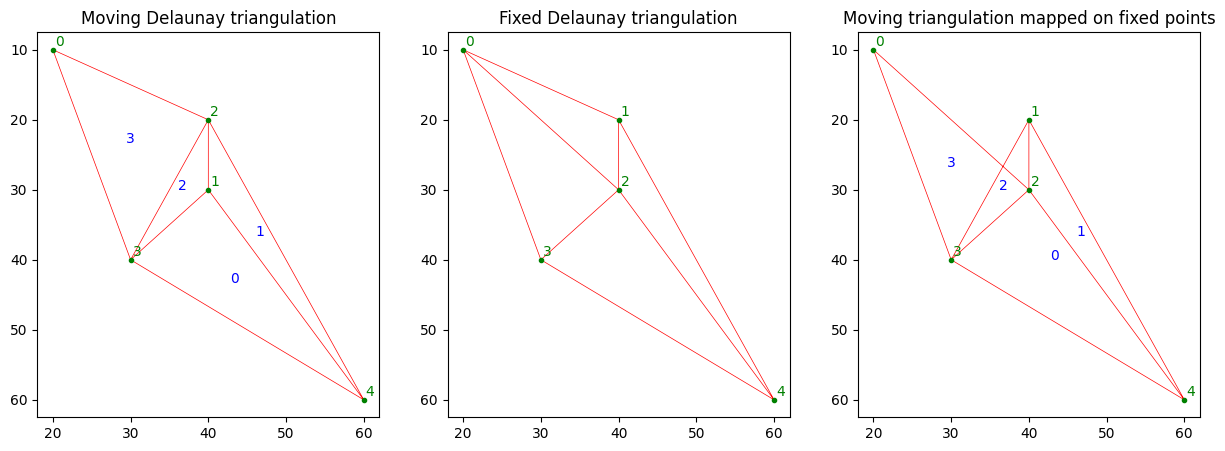

Validating triangulations...
Triangulation 1 valid (expected True): True
Triangulation 2 valid (expected True): True
Triangulation 3 valid (expected False): False


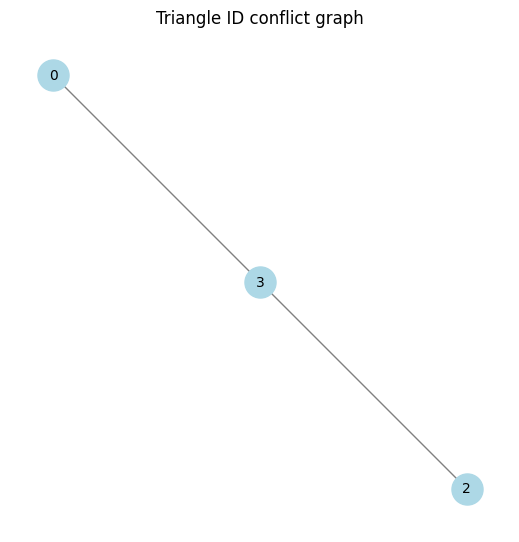

In [4]:
mpts = np.array([
    [10, 20],  # 0
    [30, 40],  # 1
    [20, 40],  # 2
    [40, 30],
    [60, 60]]) # 3


# Swap 1 and 2 around
fpts = np.array([
    mpts[0],
    mpts[2],
    mpts[1], 
    mpts[3],
    mpts[4]]) 

mtri = Delaunay(mpts)
ftri = Delaunay(fpts)

plot_triangulations(mpts, fpts, mtri, ftri, show_point_labels=True, show_triangle_labels=True)

# 4. Validate triangulations
print("Validating triangulations...")
valid_1 = validate_triangulation(mpts, mtri)
valid_2 = validate_triangulation(fpts, ftri)
valid_3 = validate_triangulation(fpts, mtri)
print(f"Triangulation 1 valid (expected True): {valid_1}")
print(f"Triangulation 2 valid (expected True): {valid_2}")
print(f"Triangulation 3 valid (expected False): {valid_3}")

show_triangle_conflict_graph(fpts, mtri, get_conflicts(fpts, mtri)) # Show conflicts

In [5]:
# Some sample points to test out on.
mpts = np.array([
    [10, 20],  # 0
    [30, 40],  # 1
    [20, 40],  # 2
    [40, 30],
    [60, 60],
    [10, 15],
    [20, 27],
    [77, 22]
    ]) # 3

# Swap indices 1 and 2 around
fpts = np.array([
    mpts[0],
    mpts[2],
    mpts[1], 
    mpts[3],
    mpts[4],
    mpts[5],
    mpts[6],
    mpts[7]
    ])

Dynamically update conflicts and remove points

Number of points: 1326


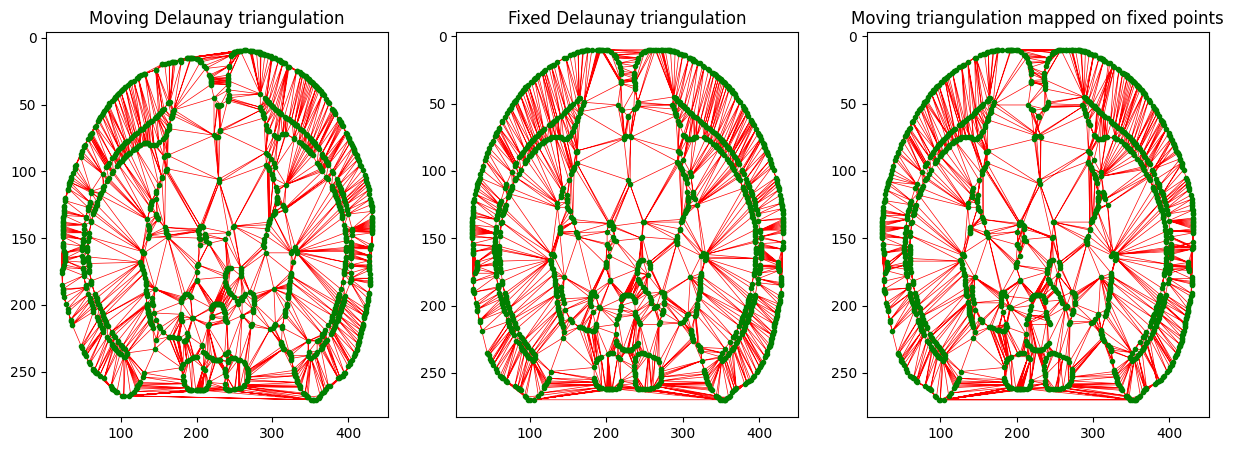

Validating the above triangulations...
Triangulation 1 valid (expected True): True
Triangulation 2 valid (expected False): False
Triangulation 3 valid (expected True): True
Initial number of triangle conflicts: 5802


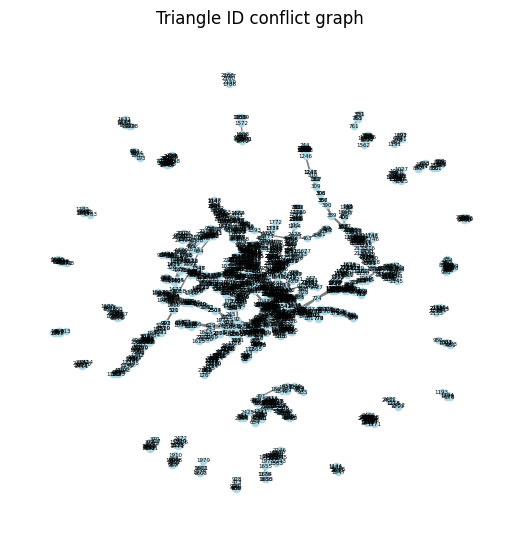


Iteration 1, current number of triangle conflicts: 5802
Iteration 2, current number of triangle conflicts: 5748
Iteration 3, current number of triangle conflicts: 5698
Iteration 4, current number of triangle conflicts: 5804
Iteration 5, current number of triangle conflicts: 5754
Iteration 6, current number of triangle conflicts: 5703
Iteration 7, current number of triangle conflicts: 5747
Iteration 8, current number of triangle conflicts: 5721
Iteration 9, current number of triangle conflicts: 5669
Iteration 10, current number of triangle conflicts: 5659
Iteration 11, current number of triangle conflicts: 5571
Iteration 12, current number of triangle conflicts: 5493
Iteration 13, current number of triangle conflicts: 5593
Iteration 14, current number of triangle conflicts: 5548
Iteration 15, current number of triangle conflicts: 5533
Iteration 16, current number of triangle conflicts: 5511
Iteration 17, current number of triangle conflicts: 5440
Iteration 18, current number of triangl

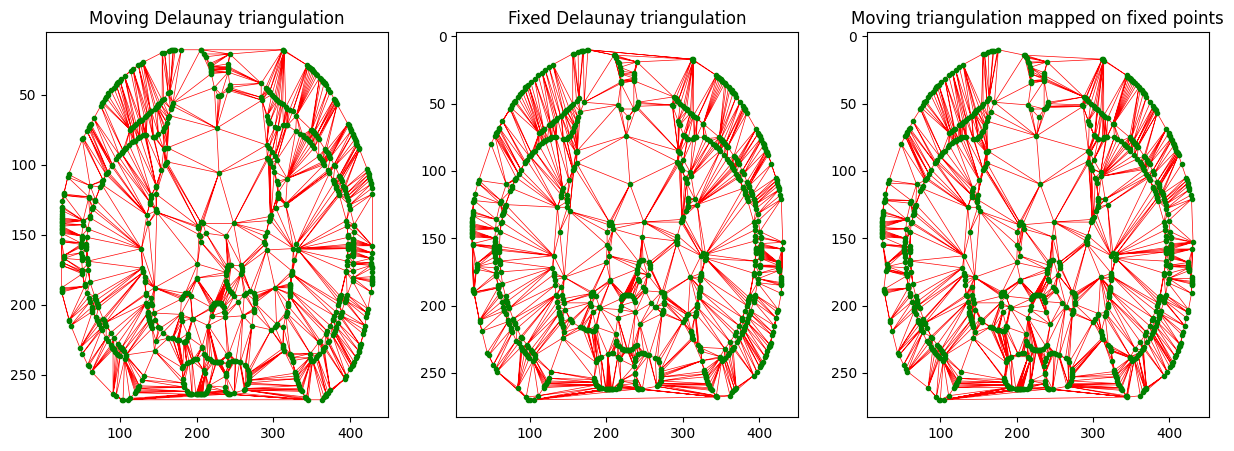

Number of points removed: 360
Points removed: {0, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 16, 17, 18, 19, 21, 23, 25, 30, 31, 33, 35, 37, 42, 43, 44, 45, 46, 47, 51, 53, 55, 63, 66, 67, 68, 73, 74, 77, 78, 81, 82, 83, 85, 92, 93, 99, 101, 102, 108, 112, 114, 117, 118, 123, 124, 128, 129, 141, 148, 152, 156, 159, 162, 167, 168, 169, 173, 174, 179, 181, 182, 188, 190, 194, 195, 197, 199, 203, 208, 209, 210, 212, 213, 214, 216, 217, 218, 220, 222, 226, 228, 229, 230, 232, 234, 238, 241, 242, 243, 247, 248, 249, 250, 252, 254, 255, 262, 268, 270, 275, 277, 279, 285, 287, 288, 289, 292, 294, 299, 304, 305, 306, 307, 308, 310, 311, 318, 322, 327, 332, 339, 341, 346, 348, 352, 355, 356, 357, 358, 360, 361, 367, 369, 374, 375, 378, 382, 384, 391, 392, 393, 394, 395, 396, 399, 402, 406, 409, 411, 418, 427, 428, 431, 434, 435, 443, 444, 446, 449, 460, 464, 472, 479, 481, 486, 489, 499, 502, 508, 511, 512, 514, 517, 519, 520, 521, 522, 525, 526, 527, 531, 533, 536, 538, 541, 542, 544, 545, 547, 548, 54

In [9]:
# Load the points
mpts = np.load("output/curr_moving.npy")[::1]
fpts = np.load("output/curr_fixed.npy")[::1]

# Parameters for shown plots
SHOW_POINT_LABELS = False    # Show point labels in plots
SHOW_TRIANGLE_IDS = False    # Show triangle IDs in plots
SHOW_ITERATION_INFO = False  # Print extra info every iteration
POINT_FONT_SIZE = 6
TRIANGLE_FONT_SIZE = 6

# Setup the triangulations
mtri = Delaunay(mpts)
ftri = Delaunay(fpts)
print("Number of points:", len(mpts))
plot_triangulations(mpts, fpts, mtri, ftri, pt_font_size=POINT_FONT_SIZE, triangle_font_size=TRIANGLE_FONT_SIZE, 
                    show_point_labels=SHOW_POINT_LABELS, show_triangle_labels=SHOW_TRIANGLE_IDS)

# Validate the triangulations
print("Validating the above triangulations...")
valid_1 = validate_triangulation(mpts, mtri)
valid_2 = validate_triangulation(fpts, mtri)
valid_3 = validate_triangulation(fpts, ftri)
print(f"Triangulation 1 valid (expected True): {valid_1}")
print(f"Triangulation 2 valid (expected False): {valid_2}")  # Should be False
print(f"Triangulation 3 valid (expected True): {valid_3}")  # Should be True

# Set up the points and triangulation
points_A = mpts.copy()
points_B = fpts.copy()
start_time = time.time()  # Start timer
tri_A = Delaunay(points_A)

# Get triangle conflicts
triangle_conflicts = get_conflicts(points_B, tri_A)
print("Initial number of triangle conflicts:", len(triangle_conflicts))
show_triangle_conflict_graph(points_B, tri_A, triangle_conflicts, node_size=20, font_size=4)  # Show conflicts
print()

# From the simplex conflicts, count how many conflicts each point has
point_conflict_count = get_point_conflicts(tri_A, triangle_conflicts)

# Build a conflict graph
conflict_graph = nx.Graph()
for nodes in triangle_conflicts:
    conflict_graph.add_edge(nodes[0], nodes[1])

# Now we will remove points with the most conflicts iteratively
points_to_remove = set()  # Keep track of points that are removed
num_iter = 0
while triangle_conflicts:
    print(f"Iteration {num_iter+1}, current number of triangle conflicts:", len(triangle_conflicts))
    
    # Find the node with the most conflicts
    simplex_id, _ = max(conflict_graph.degree, key=lambda x: x[1])
    point_ids = tri_A.simplices[simplex_id]
    point_conflict_count = get_point_conflicts(tri_A, triangle_conflicts)
    
    # Get the point with the most conflicts in the current triangle
    point_conflicts_in_simplex = {point: point_conflict_count[point] for point in point_ids}
    point_idx_with_most_conflicts = max(point_conflicts_in_simplex, key=point_conflicts_in_simplex.get)

    # Print the triangle and the point to be removed if SHOW_ITERATION_INFO is True
    if SHOW_ITERATION_INFO:
        print("Triangle ID:", simplex_id)
        print("\tTriangle point indices:", point_ids)
        print("\tTriangle points:", points_A[point_ids])
        print("\tRemoving point with the most conflicts in current triangle:", point_idx_with_most_conflicts)
        print()
    
    # Remove the point from points_A and re-triangulate
    points_to_remove.add(point_idx_with_most_conflicts)
    points_A = np.delete(points_A, point_idx_with_most_conflicts, axis=0)
    points_B = np.delete(points_B, point_idx_with_most_conflicts, axis=0)
    
    # Re-triangulate new set of points and re-check conflicts
    tri_A = Delaunay(points_A)
    triangle_conflicts = get_conflicts(points_B, tri_A)
    
    # Clear and update conflict graph
    conflict_graph.clear()
    for simplex_indices in triangle_conflicts:
        conflict_graph.add_edge(simplex_indices[0], simplex_indices[1])
    num_iter += 1

# Print the total time taken
end_time = time.time()  # End timer
print("Total time taken:", end_time - start_time, "seconds")

# Plot the final triangulation
tri_B = Delaunay(points_B)  # Just for visualization
plot_triangulations(points_A, points_B, tri_A, tri_B, 
                    pt_font_size=POINT_FONT_SIZE, triangle_font_size=TRIANGLE_FONT_SIZE,
                    show_point_labels=SHOW_POINT_LABELS, show_triangle_labels=SHOW_TRIANGLE_IDS)

# Show the results and stats
print("Number of points removed:", len(points_to_remove))
print("Points removed:", points_to_remove)
print("Remaining points:", str(len(points_B)) + "/" + str(len(mpts)))
print("Is final fixed triangulation valid:", validate_triangulation(points_B, tri_A))  # Should be True

In [10]:
#np.save("output/final_fixed.npy", points_B)  # Save the final fixed points